In [533]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import scipy
from scipy.stats import median_abs_deviation, pearsonr
import matplotlib
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
from mne_icalabel import label_components
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
%matplotlib inline

In [534]:
!ls -R nas1.tomo.nsc.ru

nas1.tomo.nsc.ru:
SUB

nas1.tomo.nsc.ru/SUB:
sub-01	sub-03	sub-04	sub-05	sub-0833  sub-0842

nas1.tomo.nsc.ru/SUB/sub-01:
index.html  ses-01

nas1.tomo.nsc.ru/SUB/sub-01/ses-01:
eeg  index.html  roi

nas1.tomo.nsc.ru/SUB/sub-01/ses-01/eeg:
index.html
sub-01_ses-01_task-dme_run-01_eegMRbvCBbviiR250.dat
sub-01_ses-01_task-dme_run-01_eegMRbvCBbviiR250.vhdr
sub-01_ses-01_task-dme_run-01_eegMRbvCBbviiR250.vmrk
sub-01_ses-01_task-dme_run-02_eegMRbvCBbviiR250.dat
sub-01_ses-01_task-dme_run-02_eegMRbvCBbviiR250.vhdr
sub-01_ses-01_task-dme_run-02_eegMRbvCBbviiR250.vmrk
sub-01_ses-01_task-inscapes_eegMRbvCBbviiR250.dat
sub-01_ses-01_task-inscapes_eegMRbvCBbviiR250.vhdr
sub-01_ses-01_task-inscapes_eegMRbvCBbviiR250.vmrk
sub-01_ses-01_task-monkey1_run-01_eegMRbvCBbviiR250.dat
sub-01_ses-01_task-monkey1_run-01_eegMRbvCBbviiR250.vhdr
sub-01_ses-01_task-monkey1_run-01_eegMRbvCBbviiR250.vmrk
sub-01_ses-01_task-monkey1_run-01_eegMRbvCBbvR250.eeg
sub-01_ses-01_task-monkey1_run-01_eegMRbvCBbvR250.vhdr
su

In [535]:
sub1_path = Path('nas1.tomo.nsc.ru/SUB/sub-01/')
sub3_path = Path('nas1.tomo.nsc.ru/SUB/sub-03/')
sub4_path = Path('nas1.tomo.nsc.ru/SUB/sub-04/')
sub5_path = Path('nas1.tomo.nsc.ru/SUB/sub-05/')
sub1_eeg = list(sub1_path.rglob("*.vhdr"))
sub1_roi = list(sub1_path.rglob("*.csv"))
sub3_eeg = list(sub3_path.rglob("*.vhdr"))
sub3_roi = list(sub3_path.rglob("*.csv"))
sub4_eeg = list(sub4_path.rglob("*.vhdr"))
sub4_roi = list(sub4_path.rglob("*.csv"))
sub5_eeg = list(sub5_path.rglob("*.vhdr"))
sub5_roi = list(sub5_path.rglob("*.csv"))

In [537]:
roi = pd.read_csv(sub1_roi[0])

In [538]:
roi.tail(20)

,Nvol,Tstart,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Left Brain-Stem,...,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens
268,269.0,562.79997,1432.95717,1357.97888,2018.71273,1588.68883,1788.77002,1509.71774,1237.57336,1173.37440,...,1482.10143,1404.58512,2071.81821,1603.04721,1885.17243,1511.73585,1257.21138,1321.58417,1407.47608,1569.52982
269,270.0,564.89997,1434.56021,1358.67497,2020.33373,1592.41928,1793.66951,1512.16599,1240.36661,1175.26685,...,1483.10700,1406.45277,2074.88907,1609.31783,1891.50070,1511.81429,1258.68039,1322.84025,1409.34530,1570.28690
270,271.0,566.99997,1433.71384,1358.85167,2015.93009,1588.50404,1790.11449,1514.65053,1242.86660,1175.48034,...,1482.48590,1404.42453,2071.74737,1606.85500,1889.30377,1510.96016,1257.37166,1325.61951,1408.70107,1573.21832
271,272.0,569.09997,1433.46165,1357.64095,2017.20399,1588.52409,1791.42124,1515.70878,1243.29878,1174.05724,...,1481.20282,1401.27082,2071.82227,1604.86556,1887.54635,1513.57120,1258.20486,1322.20370,1402.16271,1573.16078
272,273.0,571.19997,1433.27896,1356.71295,2018.31475,1589.98732,1795.94258,1517.03666,1241.69212,1171.34522,...,1480.95719,1401.38668,2072.64674,1603.44481,1888.74414,1515.35381,1254.92002,1322.88659,1402.13860,1574.28581
273,274.0,573.29997,1432.34229,1356.49745,2019.40195,1587.70546,1791.92887,1512.64387,1240.58032,1172.23827,...,1481.71788,1402.69615,2071.60543,1605.23290,1887.56166,1514.39360,1253.42980,1322.89727,1409.51868,1576.57749
274,275.0,575.39997,1433.31886,1358.07877,2018.71748,1588.57193,1795.24228,1514.54621,1238.56286,1173.56654,...,1481.91664,1404.17960,2073.06687,1604.69997,1886.19447,1512.69984,1257.43770,1325.28580,1412.00802,1570.19076
275,276.0,577.49997,1436.27991,1362.89143,2023.63151,1594.83653,1804.29070,1520.94095,1242.23210,1178.83707,...,1484.44654,1408.33996,2076.58025,1609.87464,1894.63166,1517.81279,1257.85562,1324.93915,1413.63206,1576.51617
276,277.0,579.59997,1434.70846,1360.72992,2020.26501,1593.69879,1798.34983,1517.02140,1242.14567,1173.91461,...,1483.41579,1406.98699,2073.65028,1606.46566,1890.91692,1518.11796,1258.83440,1325.06985,1412.51680,1576.76449
277,278.0,581.69997,1433.58634,1357.74375,2016.86805,1593.09229,1790.06906,1517.41206,1245.49885,1174.65371,...,1481.79663,1403.54618,2070.70601,1607.84927,1887.16460,1512.44178,1256.70331,1328.45887,1405.76446,1578.78817


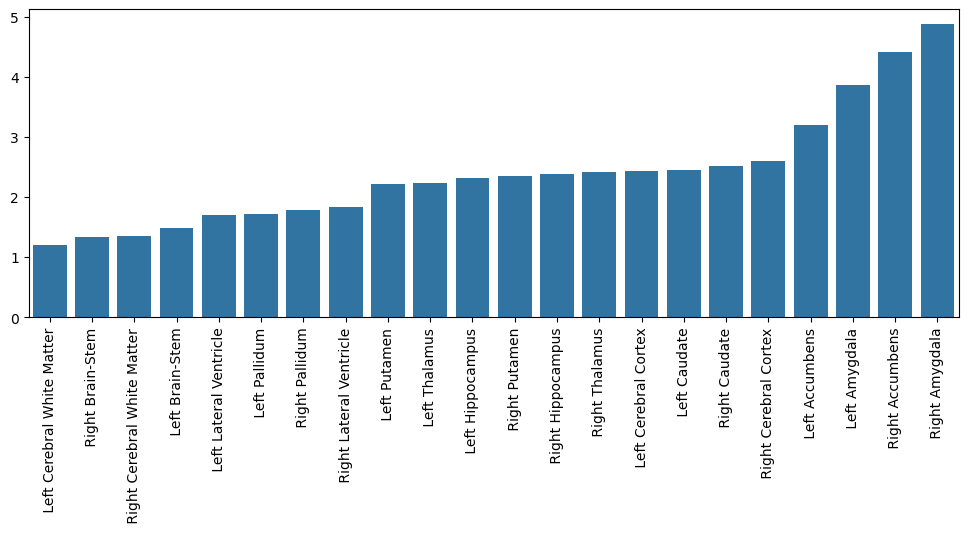

In [539]:
mads = {}
for column in roi.columns[2:]:
    mads[column] = median_abs_deviation(roi[column])
    
sorted_mads = sorted(mads.items(), key=lambda item: item[1])
sorted_mads_dict = {}
for key, value in  sorted_mads:
    sorted_mads_dict[key] = value
    
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(sorted_mads_dict, ax=ax)
ax.tick_params(axis='x', rotation=90)
plt.show()

In [545]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(10, 20, 3)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 32, 3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(4256, 120)
        self.fc1_bn = nn.BatchNorm2d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm2d(120)
        self.fc3 = nn.Linear(84, 10)
        self.fc3_bn = nn.BatchNorm2d(10)
        self.fc4 = nn.Linear(10, 1)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x


model = Net()

In [655]:
def preprocess(file_paths, X_list, y_list):
  eeg_path, roi_path = file_paths
  raw = mne.io.read_raw_brainvision(eeg_path, preload=True)
  """
  filt_raw = raw.copy().filter(l_freq=1.0, h_freq=100.0)
  filt_raw = filt_raw.set_eeg_reference("average")
  """
  roi = pd.read_csv(roi_path)
  """
  ica = ICA(
    n_components=20,
    max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
  )
  ica.fit(filt_raw)
  ic_labels = label_components(filt_raw, ica, method="iclabel")
  exclude_idx = [idx for idx, (prob, label) in enumerate(list(zip(ic_labels['y_pred_proba'], ic_labels['labels']))) 
               if label != 'brain' and prob > 0.6]
  """
  reconst_raw = raw.copy()
  #ica.apply(reconst_raw, exclude=exclude_idx)
  channels = mne.pick_channels_regexp(reconst_raw.ch_names, regexp=r"(.*[z|EEG])")
  #reconst_raw.pick_channels(['O1', 'O2', 'PO3', 'PO4', 'PO7', 'PO8'])
  filt_raw = reconst_raw.copy().filter(l_freq=0.75, h_freq=70)
  epochs = mne.make_fixed_length_epochs(filt_raw, duration=1.0, overlap=0.5)
  epochs_data = epochs.get_data()
  epo_spectrum = epochs.compute_psd(method="welch",fmin=2, fmax=40)
  psds, freqs =  epo_spectrum.get_data(return_freqs=True)
  psds /= np.sum(psds, axis=-1, keepdims=True)
  freq_table = [(2, 4), (4, 8), (8, 12), (12, 16), (16, 20), (20, 25), (25, 40)]
  data = []
  for epoch_idx, epoch in enumerate(psds):
    features = []
    for ch_idx, channel in enumerate(epoch):
        for f_min, f_max in freq_table:
            av_power = channel[(freqs >= f_min) & (freqs <= f_max)].mean()
            #feature_name = f'{epochs.ch_names[ch_idx]} [{f_min}-{f_max}]Hz'
            features.append(av_power)
    data.append(features)
  #grouped_by_channel = np.array(data).reshape(df.shape[0], 54, -1)
  data_array = np.array(data)
  roi_chosen = roi.loc[:, [' Tstart', ' Amygdala']]
  roi_chosen = roi_chosen[roi_chosen[' Tstart'] >= 12.5]
  #roi_chosen = roi_chosen[roi_chosen[' Tstart'] >= 2]
  roi_chosen.reset_index().drop('index', axis=1, inplace=True)
  y = np.array(roi_chosen[' Right Amygdala'])
  max_len = ((data_array.shape[0] - 14 ) // 5)  - 1
  #max_len = ((data_array.shape[0] - 2 ) // 2)  - 1
  y = y[:max_len]
  X = []
  for i in range(len(y)):
    #X[i] = np.transpose(grouped_by_channel[5*i : (5*i + 19)], (2, 0, 1))
    X.append(data_array[5*i : (5*i + 19)].flatten())
    #X.append(data_array[2*i : (2*i + 2)].mean(axis=0).flatten())
    #print(data_array[5*i : (5*i + 19)].shape)

  X_list.append(np.array(X))
  y_list.append(y)

In [656]:
eeg_files = sub1_eeg + sub3_eeg + sub4_eeg
roi_files = sub1_roi + sub3_roi + sub4_roi[:5] + sub4_roi[6:]
files = list(zip(eeg_files, roi_files))
X_list, y_list = [], []

for file in files:
     preprocess(file, X_list, y_list)
    
X, y = np.concatenate(X_list), np.concatenate(y_list)
#scaler = StandardScaler()
#y = scaler.fit_transform(y.reshape(-1, 1)).flatten()
#X_train_val, y_train_val, X_test, y_test = X[:int(X.shape[0] * 0.9)], y[:int(X.shape[0] * 0.9)], X[int(X.shape[0] * 0.9):], y[int(X.shape[0] * 0.9):]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

Extracting parameters from nas1.tomo.nsc.ru/SUB/sub-01/ses-01/eeg/sub-01_ses-01_task-dme_run-01_eegMRbvCBbviiR250.vhdr...
Setting channel info structure...
Reading 0 ... 151202  =      0.000 ...   604.808 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1101 samples (4.404 s)

Not setting metadata
1208 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1208 events and 250 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Using data from preloaded Raw for 1208 events and 250 original time points ...
Effective window size : 1.000 (s)


KeyError: "[' Amygdala'] not in index"

In [548]:
X_list, y_list = [], []

test_files = list(zip(sub5_eeg, sub5_roi))
for file in test_files:
     preprocess(file, X_list, y_list)
"""
z = preprocess(files[0], X_list, y_list)
"""
X_test, y_test = np.concatenate(X_list), np.concatenate(y_list)
print(y_test.mean())

Extracting parameters from nas1.tomo.nsc.ru/SUB/sub-05/ses-01/eeg/sub-05_ses-01_task-dme_run-01_eegMRbvCBbviiR250.vhdr...
Setting channel info structure...
Reading 0 ... 151727  =      0.000 ...   606.908 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1101 samples (4.404 s)

Not setting metadata
1212 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 

In [549]:
import xgboost as xgb

In [550]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators':  hp.randint('n_estimators', 50, 100),
        'seed': 0
    }

In [551]:
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = clf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    print ("SCORE:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [552]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
66.35713969728259                                                               
 10%|█          | 1/10 [00:03<00:32,  3.65s/trial, best loss: 66.35713969728259]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
62.70282671487269                                                               
 20%|██▏        | 2/10 [00:06<00:23,  2.93s/trial, best loss: 62.70282671487269]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
64.72491909862185                                                               
 30%|███▎       | 3/10 [00:12<00:31,  4.55s/trial, best loss: 62.70282671487269]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
65.2093606273185                                                                
 40%|████▍      | 4/10 [00:14<00:21,  3.51s/trial, best loss: 62.70282671487269]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
65.65221130071312                                                               
 50%|█████▌     | 5/10 [00:20<00:22,  4.47s/trial, best loss: 62.70282671487269]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
61.5268973977144                                                                
 60%|███████▏    | 6/10 [00:23<00:16,  4.06s/trial, best loss: 61.5268973977144]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
66.54963288268642                                                               
 70%|████████▍   | 7/10 [00:32<00:16,  5.63s/trial, best loss: 61.5268973977144]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
67.44133067516614                                                               
 80%|█████████▌  | 8/10 [00:46<00:16,  8.12s/trial, best loss: 61.5268973977144]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
66.71135664808946                                                               
 90%|██████████▊ | 9/10 [00:55<00:08,  8.57s/trial, best loss: 61.5268973977144]

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/rich/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
63.022272398118304                                                              
100%|███████████| 10/10 [00:56<00:00,  5.68s/trial, best loss: 61.5268973977144]


In [553]:
best_hyperparams

{'colsample_bytree': 0.9570907435964933,
 'gamma': 5.5561733975062975,
 'max_depth': 6.0,
 'min_child_weight': 3.0,
 'n_estimators': 96,
 'reg_alpha': 169.0,
 'reg_lambda': 0.8917711787201985}

In [629]:
clf=xgb.XGBRegressor(colsample_bytree=0.9570907435964933, gamma=5.5561733975062975, max_depth=6, min_child_weight=3,
                    n_estimators=96, reg_alpha=169, reg_lambda=0.8917711787201985)
clf.fit(X, y)
print(y.mean())
print(y_test.mean())
y_preds = clf.predict(X_test)
print(y_preds.mean())
t = np.linspace(0, len(y_preds), len(y_preds))

1276.6450102456067
1146.433627543538
1250.2234


<Axes: xlabel='time', ylabel='value'>

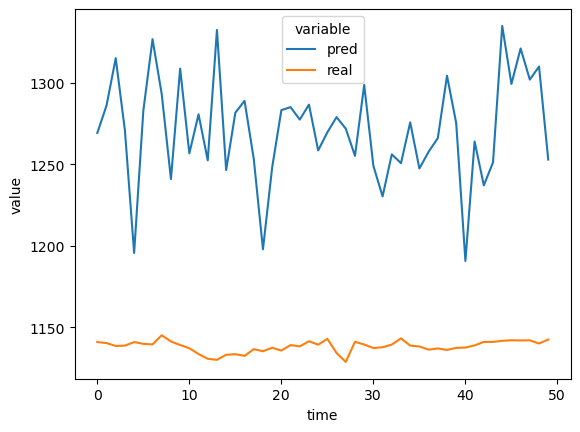

In [630]:
data_preproc = pd.DataFrame({
    'time' : t[:50],
    'pred': y_preds[:50], 
    'real': y_test[:50]})
sns.lineplot(x='time', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['time']))

In [631]:
pearsonr(y_test, y_preds)

PearsonRResult(statistic=-0.06818137767453337, pvalue=0.02431658017761664)

In [632]:
reg = LinearRegression()
reg.fit(X, y)
y_preds = reg.predict(X_test)

In [633]:
data_preproc = pd.DataFrame({
    'time' : t[:50],
    'pred': y_preds[:50], 
    'real': y_test[:50]})

<Axes: xlabel='time', ylabel='value'>

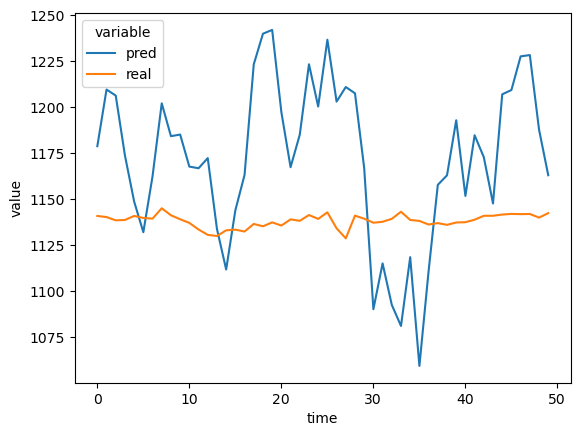

In [634]:
sns.lineplot(x='time', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['time']))

In [635]:
pearsonr(y_test, y_preds)

PearsonRResult(statistic=0.02660817893856757, pvalue=0.37993080077114094)

In [645]:
reg = LinearRegression()
reg.fit(X, y)
y_preds = reg.predict(X)

In [646]:
data_preproc = pd.DataFrame({
    'time' : t[:50],
    'pred': y_preds[:50], 
    'real': y[:50]})

<Axes: xlabel='time', ylabel='value'>

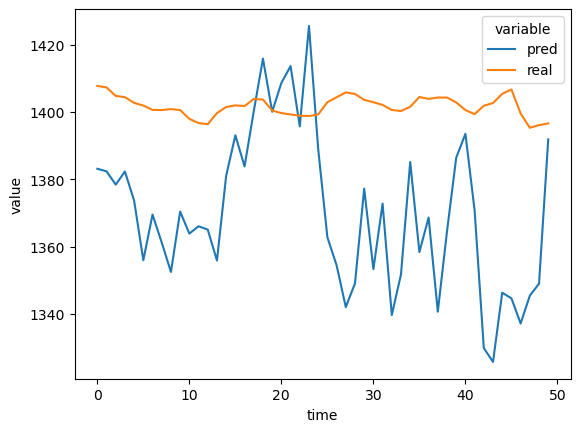

In [647]:
sns.lineplot(x='time', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['time']))

In [648]:
pearsonr(y, y_preds)

PearsonRResult(statistic=0.8901035405402938, pvalue=0.0)

In [649]:
clf=xgb.XGBRegressor(colsample_bytree=0.9570907435964933, gamma=5.5561733975062975, max_depth=6, min_child_weight=3,
                    n_estimators=96, reg_alpha=169, reg_lambda=0.8917711787201985)
clf.fit(X, y)
print(y.mean())
print(y_test.mean())
y_preds = clf.predict(X)
print(y_preds.mean())
t = np.linspace(0, len(y_preds), len(y_preds))

1276.6450102456067
1146.433627543538
1276.651


<Axes: xlabel='time', ylabel='value'>

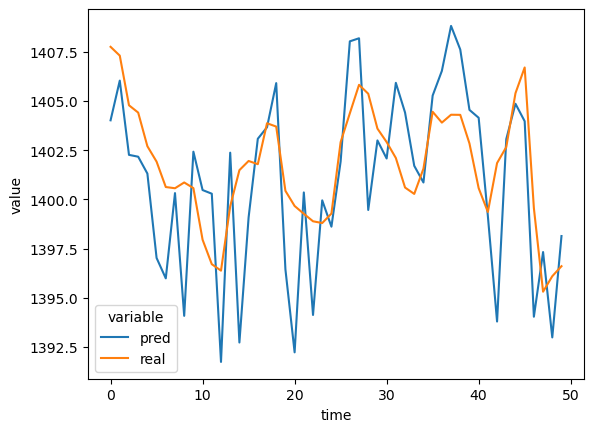

In [651]:
data_preproc = pd.DataFrame({
    'time' : t[:50],
    'pred': y_preds[:50], 
    'real': y[:50]})
sns.lineplot(x='time', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['time']))

In [652]:
pearsonr(y, y_preds)

PearsonRResult(statistic=0.9984986551481646, pvalue=0.0)